<a href="https://colab.research.google.com/github/areeba42197/imdbReviews/blob/main/imdbReviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing libraries**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, BatchNormalization, Flatten, GlobalAveragePooling1D

from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.metrics import Accuracy, AUC, Precision, Recall
from sklearn.metrics import classification_report



**Loading Data**

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


In [34]:
df=pd.read_csv(path+"/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   review           50000 non-null  object
 1   sentiment        50000 non-null  object
 2   cleaned_reviews  50000 non-null  object
 3   label            50000 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.5+ MB


In [35]:
df['review']=df['review'].str.lower()

In [36]:
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. <br /><br />the...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive


**Preprocessing data**

Removing html tags , punctuations , digits , spaces , stopwords


In [7]:
import re

In [37]:
def clean_text(text):

    text = re.sub(r'<.*?>', '', text)               # remove HTML tags (like <br>)
    text = re.sub(r'[^a-zA-Z\s]', '', text)         # remove punctuation and digits
    text = re.sub(r'\s+', ' ', text).strip()        # remove extra spaces
    return text



In [38]:
df['cleaned_reviews']=df['review'].apply(clean_text)

In [39]:
df.head()

,review,sentiment,cleaned_reviews
0,one of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,a wonderful little production. <br /><br />the...,positive,a wonderful little production the filming tech...
2,i thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,basically there's a family where a little boy ...,negative,basically theres a family where a little boy j...
4,"petter mattei's ""love in the time of money"" is...",positive,petter matteis love in the time of money is a ...


In [40]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
  words=text.split()
  filtered_words=[word for word in words if word.lower() not in stop_words]
  return ' '.join(filtered_words)




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
df['cleaned_reviews']=df['cleaned_reviews'].apply(remove_stopwords)

In [31]:
df.head()

,review,sentiment,cleaned_reviews,label
0,one of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching oz episode yo...,1
1,a wonderful little production. <br /><br />the...,positive,wonderful little production filming technique ...,1
2,i thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...,1
3,basically there's a family where a little boy ...,negative,basically theres family little boy jake thinks...,0
4,"petter mattei's ""love in the time of money"" is...",positive,petter matteis love time money visually stunni...,1


**Tokenize data and vectorization**

In [42]:


# Set max vocab size and OOV token
vocab_size = 10000
oov_token = "<OOV>"

# Initialize and fit tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(df['cleaned_reviews'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['cleaned_reviews'])


In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features
X = vectorizer.fit_transform(df['cleaned_reviews']).toarray()  # Assuming 'clean_text' has preprocessed text


In [45]:
df['label']=df['sentiment'].map({'positive':1,'negative':0})

In [46]:
df.head()

,review,sentiment,cleaned_reviews,label
0,one of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching oz episode yo...,1
1,a wonderful little production. <br /><br />the...,positive,wonderful little production filming technique ...,1
2,i thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...,1
3,basically there's a family where a little boy ...,negative,basically theres family little boy jake thinks...,0
4,"petter mattei's ""love in the time of money"" is...",positive,petter matteis love time money visually stunni...,1


In [48]:
y=df['label'].values

**Tesy Train split**

In [80]:
X_train , X_test , y_train , y_test=train_test_split(X,y , random_state=42 , test_size=0.3)

**Model training (Neural Network)**



This neural network uses two hidden layers with reduced units and strong regularization (L2 + Dropout) to prevent overfitting. Batch normalization helps stabilize training. The final sigmoid layer is used for binary classification.

In [81]:

model = tf.keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),

    # Hidden Layer 1 (reduced units + stronger dropout)
    layers.Dense(62, activation='relu',
                 kernel_initializer='he_normal',
                 kernel_regularizer=regularizers.l2(0.002)),
    layers.BatchNormalization(),  # Normalize activations
    layers.Dropout(0.5),  # Increased dropout

    # Hidden Layer 2 (reduced units + stronger dropout)
    layers.Dense(16, activation='relu',
                 kernel_initializer='he_normal',
                 kernel_regularizer=regularizers.l2(0.002)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Output Layer
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 62)             │       310,062 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 62)             │           248 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 62)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │         1,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 311,399 (1.19 MB)

 Trainable params: 311,243 (1.19 MB)

 Non-trainable params: 156 (624.00 B)

In [82]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [83]:
from tensorflow.keras.callbacks import EarlyStopping


history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=32,
    verbose=2,
)
# Add the early_stop callback here


Epoch 1/10
985/985 - 12s - 12ms/step - accuracy: 0.8081 - loss: 0.6626 - val_accuracy: 0.8703 - val_loss: 0.5077
Epoch 2/10
985/985 - 9s - 9ms/step - accuracy: 0.8697 - loss: 0.5139 - val_accuracy: 0.8723 - val_loss: 0.4784
Epoch 3/10
985/985 - 10s - 10ms/step - accuracy: 0.8741 - loss: 0.4914 - val_accuracy: 0.8694 - val_loss: 0.4746
Epoch 4/10
985/985 - 7s - 7ms/step - accuracy: 0.8750 - loss: 0.4841 - val_accuracy: 0.8714 - val_loss: 0.4711
Epoch 5/10
985/985 - 9s - 10ms/step - accuracy: 0.8765 - loss: 0.4772 - val_accuracy: 0.8740 - val_loss: 0.4681
Epoch 6/10
985/985 - 8s - 8ms/step - accuracy: 0.8769 - loss: 0.4771 - val_accuracy: 0.8694 - val_loss: 0.4627
Epoch 7/10
985/985 - 10s - 10ms/step - accuracy: 0.8763 - loss: 0.4725 - val_accuracy: 0.8743 - val_loss: 0.4602
Epoch 8/10
985/985 - 10s - 10ms/step - accuracy: 0.8776 - loss: 0.4681 - val_accuracy: 0.8751 - val_loss: 0.4498
Epoch 9/10
985/985 - 11s - 11ms/step - accuracy: 0.8794 - loss: 0.4611 - val_accuracy: 0.8763 - val_los

In [85]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8810 - loss: 0.4446
Test Accuracy: 0.8762


**Visualizing Accuracy and Loss to check overfitting or underfitting**

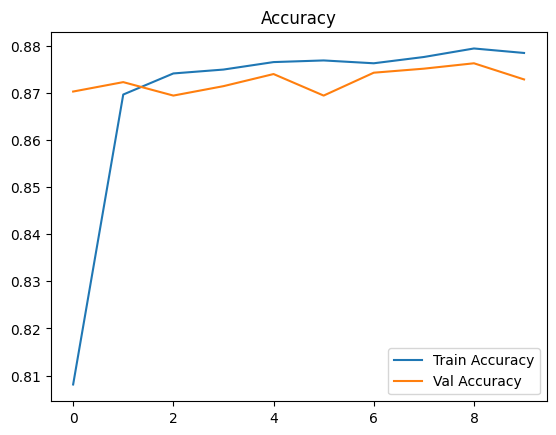

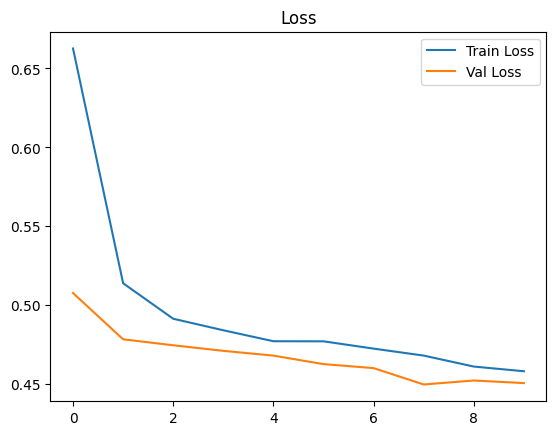

In [84]:

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()


**Bias and Variance**

In [90]:
train_accuracies = []
val_accuracies = []

train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

print(f"Train Accuracy: {train_acc:.4f} | Validation Accuracy: {val_acc:.4f}")
train_accuracies.append(train_acc)
val_accuracies.append(val_acc)

# Removed fold += 1 as there's no loop for cross-validation in the current code

mean_train_acc = np.mean(train_accuracies)
mean_val_acc = np.mean(val_accuracies)
print("\n===== Bias-Variance Report =====")
print(f"Average Training Accuracy: {mean_train_acc:.4f}")
print(f"Average Validation Accuracy: {mean_val_acc:.4f}")
print(f"Accuracy Gap (Train - Val): {mean_train_acc - mean_val_acc:.4f}")



Train Accuracy: 0.8785 | Validation Accuracy: 0.8729

===== Bias-Variance Report =====
Average Training Accuracy: 0.8785
Average Validation Accuracy: 0.8729
Accuracy Gap (Train - Val): 0.0056


Results show that model is working well and there are no signs of overfitting or underfitting . Bias and variance both are low
